In [1]:
###### INFORM .py files necessary for processing aircraft data
import inform_utils as inform # INFORM python module inform_utils.py
import process_data_products_utils as pdp # INFORM python module, process_data_products
#######

import xarray as xr
from datetime import time
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm, trange
import dask

### This script is used to read in raw 1Hz aircraft data and produce 

# Individual flight analysis

## 1. Load aircraft data into pandas dataframe

In [9]:
dir = '/glade/work/patnaude/CSET/aircraft_1hz/'

flight_number = 5 # Select Research Flight

df = inform.load_flight_data(dir,flight_number-1) # 0 is Index of research flight

Issue reading CONCHDC_LWII: If using all scalar values, you must pass an index


## 2. Block flight maneuvers 

In [6]:
blocks = pdp.VAP_process_flight_data(df,5)

### optional, plot flight profile with blocked flight maneuvers

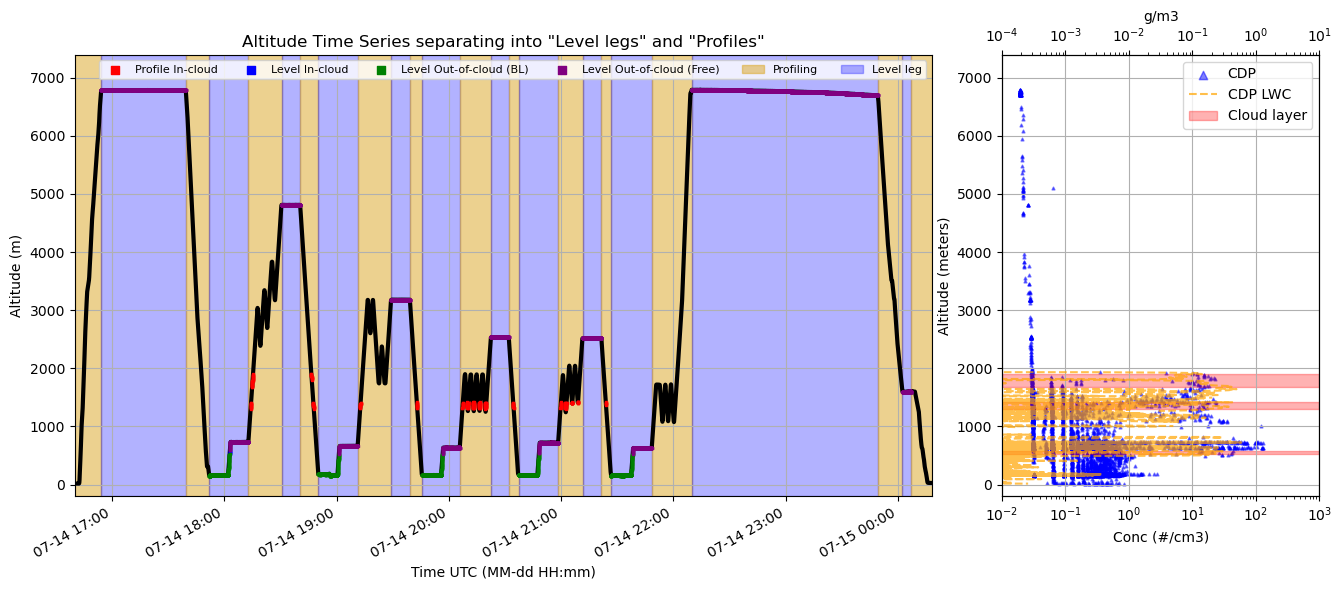

In [10]:
dict = pdp.assign_flight_type(df)
pdp.plot_block_ts(dict,5)

## 3. Collocate ERA5 data

In [14]:
# Select ERA5 dataset for Aircraft Campaign Time Frame
ds = pdp.select_ERA5_4flight(df) 
# Collocate ERA5 data and calculate environmental controlling factors
fblks_coll = pdp.collocate_ERA5_dat(ds, blocks)
# Select cloud regime type based on cloud controlling factors
fblks_cr = pdp.cloud_regime_old(fblks_coll)


Collocating flight blocks:   0%|          | 0/4 [00:00<?, ?it/s]

## 4. Save data as netCDF

In [15]:
rf_id = f"RF{flight_number:02d}"
write_RF_nc(fblks_cr, rf_id)

# Process all flights

* #### Here you simply select which campaign you would like to process (SOCRATES or CSET) and this will loop through all flights and produce composited datasets saved in netCDF format
* #### Run cell below to utilize dask parallel computing to improve speed of producing composited netCDFs

### Create dask cluster for parallel computing for time efficiency

In [3]:
cluster = PBSCluster(
    cores = 1,
    memory = '30GB',
    processes = 1,
    queue = 'casper',
    local_directory = '$TMPDIR',
    resource_spec = 'select=1:ncpus=1:mem=30GB',
    project='P04010022',
    walltime='01:00:00',
    interface='mgt')

# scale up
cluster.scale(12)

# change your urls to the dask dashboard so that you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

Task exception was never retrieved
future: <Task finished name='Task-13662' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-13655' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-13650' coro=<Client._gather.<locals

In [3]:
campaign = 'SOCRATES' # SOCRATES or CSET

if campaign == 'SOCRATES':
    dir = '/glade/work/patnaude/SOCRATES/aircraft_1hz/'
elif campaign  == 'CSET':
    dir = '/glade/work/patnaude/CSET/aircraft_1hz/'
        
flight_paths = inform.find_flight_fnames(dir)
all_fblks = {}

for i in tqdm(range(0,len(flight_paths))):
    df = inform.load_flight_data(dir, i)
    if ('PLWC' in df.columns) and (campaign == 'SOCRATES'): # RF12 is the only fligth with this variable and it messes up the final product
        df = df.drop(columns=['PLWC'])
    blocks = pdp.VAP_process_flight_data(df, i)

    # Select ERA5 data
    ds = pdp.select_ERA5_4flight(df, campaign)
    rf_id = f"RF{i+1:02d}"
    print(rf_id)
          
    # Collocate ERA5 data and calculate environmental controlling factors
    fblks_coll = pdp.collocate_ERA5_dat(ds, blocks)
    # Select cloud regime type based on cloud controlling factors
    fblks_cr = pdp.cloud_regime(fblks_coll, campaign=campaign)
    # Write to NetCDF for this flight
    pdp.write_RF_nc(fblks_cr, rf_id, campaign)

    # Save to master dictionary
    # all_fblks[rf_id] = fblks_cr

  0%|          | 0/15 [00:00<?, ?it/s]

RF01
Wrote SOCRATES_RF01.nc
RF02
Wrote SOCRATES_RF02.nc
RF03
Wrote SOCRATES_RF03.nc
RF04
Wrote SOCRATES_RF04.nc
RF05
Wrote SOCRATES_RF05.nc
RF06
Wrote SOCRATES_RF06.nc
RF07
Wrote SOCRATES_RF07.nc
RF08
Wrote SOCRATES_RF08.nc
RF09
Wrote SOCRATES_RF09.nc
RF10
Wrote SOCRATES_RF10.nc
RF11
Wrote SOCRATES_RF11.nc
RF12
Wrote SOCRATES_RF12.nc
RF13
Wrote SOCRATES_RF13.nc
RF14
Wrote SOCRATES_RF14.nc
RF15
Wrote SOCRATES_RF15.nc
